# Avaliação de Performance e Inferência
Este notebook carrega os modelos treinados e os dados de teste persistidos anteriormente. O foco aqui é a comparação de métricas, análise de interpretabilidade e teste de uso prático.

## 1. Imports e Caminhos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
)

path_models = '../../../models/'
path_processed = '../../../data/processed/'

## 2. Carregando Dados Salvos

In [2]:
X_test = pd.read_csv(os.path.join(path_processed, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(path_processed, 'y_test.csv'))

features_list = joblib.load(os.path.join(path_models, 'features_list.pkl'))
scaler = joblib.load(os.path.join(path_models, 'scaler_olist.pkl'))
modelos = joblib.load(os.path.join(path_models, 'modelos_treinados_olist.pkl'))

X_test_scaled = scaler.transform(X_test)

## 3. Avaliação Comparativa de Desempenho

Nesta etapa, consolidamos os resultados dos 5 modelos otimizados via GridSearchCV (KNN, Regressão Logística, Árvore de Decisão, Random Forest e MLP).

Realizando os seguintes procedimentos:
1.  Geração de Previsões: Utiliza a massa de teste escalada (X_test_scaled) para simular o cenário real.
2.  Cálculo de Métricas: Avalia cada modelo segundo:
    * Acurácia (Taxa de acerto global);
    * Precision e Recall (Qualidade dos positivos);
    * F1-Score (Média harmônica, usada como critério principal de desempate).
3.  Visualização Gráfica: Plota as Matrizes de Confusão lado a lado para analisar erros (Falsos Positivos vs. Falsos Negativos).
4.  Ranking Final: Exibe uma tabela ordenada pelo F1-Score e imprime automaticamente o modelo vencedor.

TABELA COMPARATIVA DE PERFORMANCE


,Acurácia,F1-Score,Recall,Precision
Modelo,,,,
Regressão Logística,0.785302,0.871603,0.947356,0.807067
Random Forest,0.770849,0.852547,0.861211,0.844056
MLP (Rede Neural),0.759215,0.850288,0.888922,0.814873
KNN,0.730719,0.820471,0.799941,0.842082
Árvore de Decisão,0.707858,0.801947,0.768922,0.837937


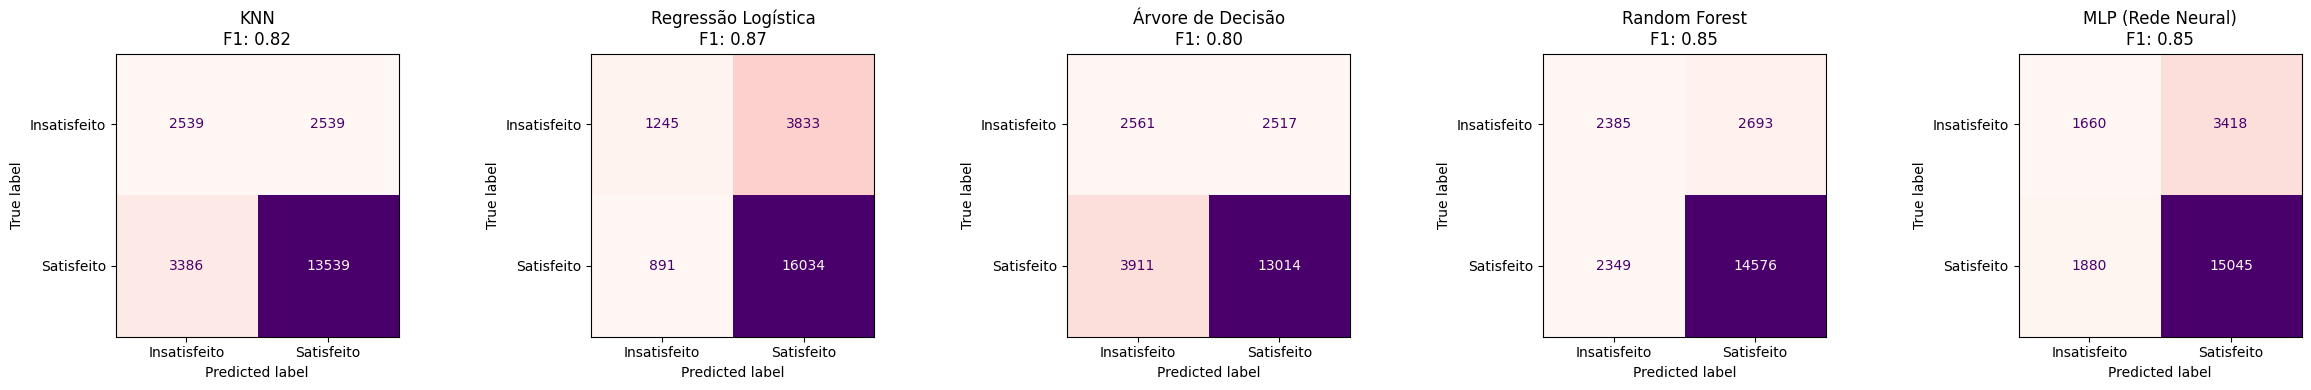


O melhor modelo para este problema foi: Regressão Logística (F1: 0.8716)
Melhores parâmetros encontrados:
C: 0.1
penalty: l1


In [3]:
resultados = []

fig, axes = plt.subplots(1, 5, figsize=(24, 4))

for i, (nome, modelo) in enumerate(modelos.items()):
    # Predição automática com o melhor estimador do GridSearch
    y_pred = modelo.predict(X_test_scaled)

    # calculo de métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="binary")
    rec = recall_score(y_test, y_pred, average="binary")
    prec = precision_score(y_test, y_pred, average="binary")

    resultados.append(
        {
            "Modelo": nome,
            "Acurácia": acc,
            "F1-Score": f1,
            "Recall": rec,
            "Precision": prec,
            "Configuração": modelo.best_params_
        }
    )

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=axes[i],
        cmap="RdPu",
        colorbar=False,
        display_labels=["Insatisfeito", "Satisfeito"],
    )
    axes[i].set_title(f"{nome}\nF1: {f1:.2f}")

df_resultados = pd.DataFrame(resultados).set_index("Modelo")
df_resultados = df_resultados.sort_values(by="F1-Score", ascending=False)

print("TABELA COMPARATIVA DE PERFORMANCE")
display(df_resultados.drop(columns=["Configuração"])) 

plt.tight_layout()
plt.show()

melhor_modelo = df_resultados.index[0]
melhor_f1 = df_resultados.iloc[0]["F1-Score"]
melhores_ajustes = df_resultados.iloc[0]["Configuração"]

print(
    f"\nO melhor modelo para este problema foi: {melhor_modelo} (F1: {melhor_f1:.4f})"
)
print("Melhores parâmetros encontrados:")
for param, valor in melhores_ajustes.items():
    print(f"{param}: {valor}")

## 5. Análise de Importância dos Atributos

Ao contrário da suposição feita, o atraso do pedido não é o principal influenciador de satisfação. 

Principais Observações:
1. O custo logístico (frete) mostra ser o atributo mais importante indicando que o valor pago pelo transporte tem um peso decisivo na percepção de valor do cliente.
2. O preço do produto aparece como o segundo fator de maior influência.
3. Peso e dimensões superam o impacto do atraso, sugerindo que a expectativa sobre o produto físico vs. custo total domina a experiência de compra neste recorte de dados.

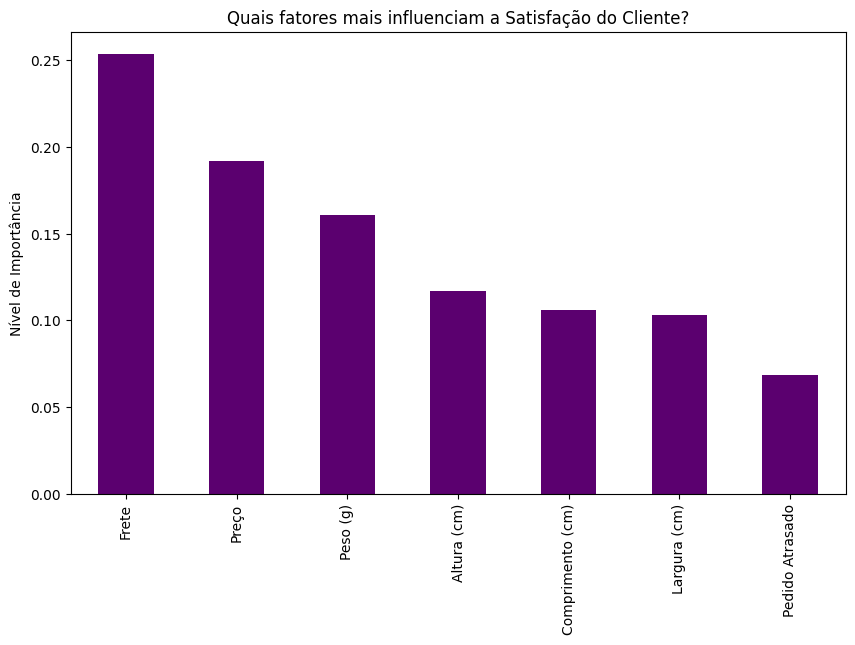

In [6]:
variaveis = {
    'price': 'Preço',
    'freight_value': 'Frete',
    'product_weight_g': 'Peso (g)',
    'product_length_cm': 'Comprimento (cm)',
    'product_height_cm': 'Altura (cm)',
    'product_width_cm': 'Largura (cm)',
    'atrasado': 'Pedido Atrasado'
}

melhor_rf = modelos['Random Forest'].best_estimator_

importances = pd.Series(melhor_rf.feature_importances_, index=features_list)
importances.index = importances.index.map(variaveis)
importances = importances.sort_values(ascending=False)

cmap = plt.cm.RdPu

plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color=cmap(0.95))
plt.title("Quais fatores mais influenciam a Satisfação do Cliente?")
plt.ylabel("Nível de Importância")
plt.savefig('../../../reports/figures/importancia_atributos.png', bbox_inches='tight')
plt.show()